In [1]:
import sys,os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import rdlib.rdlib4 as rd

# from sympy import *
from sympy import diff,Symbol,Matrix,symbols,solve,simplify,binomial
from sympy.abc import a,b,c
# init_session()
from sympy import var
px,py =var('px:4'),var('py:4')

# Google Colaboratory の MyDrive パス
COLABRDROOT = "/content/drive/My Drive/RadiShLab"

# ホーム
LOCALHOME = "."  # フォルダを絶対指定するならここを書き変えてください


# 環境判定（Google Colaboratory かどうかの判定）
try:
    from google.colab import drive
    drive.mount('/content/drive')
    sys.path.append(COLABRDROOT+'/rdlib')
    COLABORATORY = True
except ImportError:
    sys.path.append('./rdlib')
    COLABORATORY = False
import rdlib4 as rd

# フォルダ指定
labhome = COLABRDROOT if COLABORATORY else LOCALHOME


NSilF = './RDSamples/NSilImages' # 正規化されたシルエット画像のフォルダ
imgs = rd.collectimages(NSilF)       # シルエット画像のリスト

輪郭線の画素数は、左 303  右294


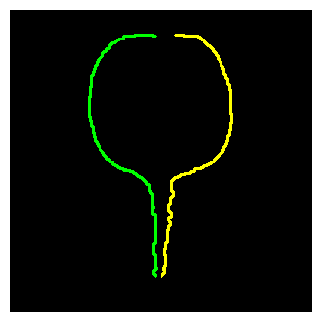

In [5]:
# 画像の左右の輪郭線を抽出　（S5参照）
img = imgs[4]
conLeft,conRight = rd.getCntPairWithImg(img)
canvas = cv2.cvtColor(np.zeros_like(img) ,cv2.COLOR_GRAY2BGR)
rd.drawContours(canvas,conLeft,color=(0,255,0),thickness=2)
rd.drawContours(canvas,conRight,color=(0,255,255),thickness=2)
plt.figure(dpi=100)
rd.plotimg(canvas)
print("輪郭線の画素数は、左 {}  右{}".format(len(conLeft),len(conRight)))

輪郭線を構成する画素の数は、この例で左右それぞれ300画素近い。

## getSamples()
> rd.getSamples(cont,N=20,mode='Equidistant')
    # 入力
    # 　cont 輪郭線構造体 開いた輪郭線を想定している
    # 　N サンプル数
    # パラメータ
    #　 mode = 'Equidistant'なら始点からの距離について等間隔 (default)
    # 　mode = 'Simple' なら単純にインデックスを等間隔

ディジタル画像は斜め方向と上下左右とで画素間の距離が異なるので、単純にインデックスを等間隔に刻むと、輪郭が斜めになっている部分と縦横に伸びている部分とでサンプリング間隔が変化してしまう。

曲線あてはめにはそれほど影響しないが、気にする場合は Equidistantを用いるとよい。

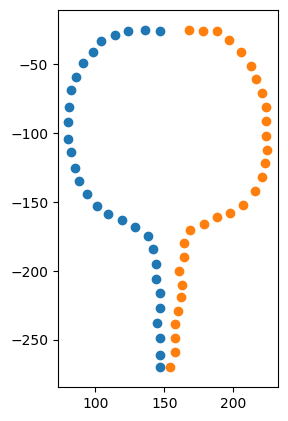

In [23]:
Left = rd.getSamples(conLeft,N=30,mode='Equidistant')
Right = rd.getSamples(conRight,N=30,mode='Simple')

plt.figure(figsize=(5,5),dpi=100)
g = plt.subplot()
g.set_aspect('equal')
plt.scatter(Left[:,0],-Left[:,1])
plt.scatter(Right[:,0],-Right[:,1]);

左が距離等間隔、右がインデックスの等間隔

# ベジエ曲線のあてはめ

## class BezierCurve:
## BezierCurve()　（コンストラクタ）
> rd.BezierCurve(samples, N=5, initialPara=[], openmode=False)
    # 入力
    #    samples   輪郭の標本
    #    N  ベジエ曲線の次数
    #    initialPara   サンプルに対するベジエ関数のパラメータの初期値
    #      デフォルトは[]であり、その場合は初期値はリニアとなる
    # パラメータ
    #    openmode=False  # 端点を自由扱い　False のときは曲線の端点をサンプルの端点位置に一致させる
    # 出力
    #    BezierCurve のインスタンス
    
> bez = BezierCurve(con,N=5)
    
> bez.fit()  あてはめの実行

> rd.BezierCurve.toggledebugmode()   デバッグ情報のオンオフ

> rd.BezierCurve.setParameters(reset=False,precPara=0.1,errorThres=0.5,paraResolution = 0.001)  パラメータの表示とセット

> クラス変数
    # precPara = 0.1 # 繰り返しにおけるパラメータ変動幅の平均値に対するしきい値
    # errorThres = 0.5 # 繰り返し打ち切りを決める、あてはめ誤差の平均値に対するしきい値
    # paraResolution = 0.001 # サンプル点の最寄り点探索の解像度
    

# 実行例

In [25]:
rd.BezierCurve.setParameters()

precPara:        0.1
errorThres:      0.5
paraResolution:  0.001
debugmode:       False



In [30]:
cntL = rd.getSamples(conLeft,N=20)
cntR = rd.getSamples(conRight,N=20)
bezL =  rd.BezierCurve(cntL,N=6)
bezR =  rd.BezierCurve(cntR,N=6)
rd.BezierCurve.toggledebugmode() # デバッグモードの切り替え
# BezierCurve.setParameters(precPara=1.0,errorThres=1.0)
res,cpx,cpy,LbezresX,LbezresY,tpara = bezL.fit()
res,cpx,cpy,RbezresX,RbezresY,tpara = bezR.fit()
# BezierCurve.setParameters()



debugmode: False
.......
.......


# 結果の描画

##  drawBez()
> drawBez(rdimg,bezL=None,bezR=None,bezC=None,cpl=None,cpr=None,cpc=None, 
             cntL=[],cntR=[],cntC=None, ladder=None,PosL=[],PosR=[],PosC=[],n_samples=20,saveImage=False,savepath="")
             
    # 入力
    #    rdimg  シルエット画像
    #    bezL,bezR,bezC   ベジエ曲線の定義式　3本まで描ける
    #    cpl,cpr,cpc     ベジエ曲線の制御点
    #    cntL,cntR,cntC  標本点
    # パラメータ
    #    ladder  標本点間を結ぶ線分を描画するかどうか
    #    PosL,PosR.PosC ラダーの設置点
    #    n_samples  ラダーの数
    #    saveImage 画像を保存するかどうか
    #    savepath ファイル名
    

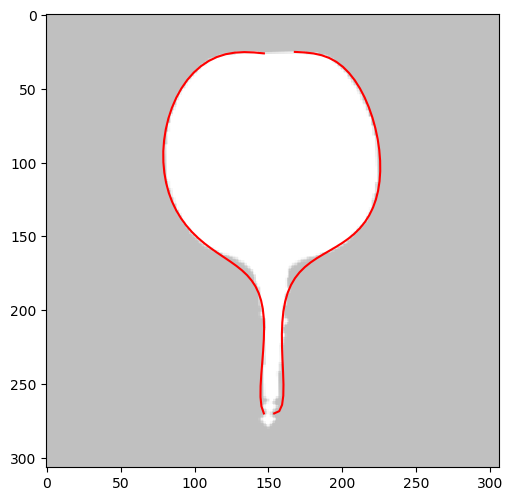

In [31]:
rd.drawBez2(img,bezL=(LbezresX,LbezresY),bezR=(RbezresX,RbezresY))